## Don't Get Kicked!

Mengyu Liu

May 29, 2023

**Problem description**

One of the biggest challenges of an auto dealership purchasing a used car at an auto auction is the risk of that the vehicle might have serious issues that prevent it from being sold to customers. The auto community calls these unfortunate purchases "kicks".

Kicked cars often result when there are tampered odometers, mechanical issues the dealer is not able to address, issues with getting the vehicle title from the seller, or some other unforeseen problem. Kick cars can be very costly to dealers after transportation cost, throw-away repair work, and market losses in reselling the vehicle.

Modelers who can figure out which cars have a higher risk of being kick can provide real value to dealerships trying to provide the best inventory selection possible to their customers.

The challenge of this project is to predict if the car purchased at the Auction is a Kick (bad buy).

In [ ]:
import pandas as pd
import numpy as np
#from catboost import CatBoostClassifier
#from sklearn.model_selection import StratifiedKFold,KFold,GroupKFold
#from sklearn.metrics import accuracy_score

#Pipeline
#from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import make_column_transformer
from imblearn.pipeline import Pipeline,make_pipeline

#For Missing Value and Feature Engineering
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler,SMOTE


from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold,cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
%matplotlib inline
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,recall_score,precision_score,f1_score,roc_curve, auc,accuracy_score,roc_auc_score,precision_recall_curve
from sklearn.metrics import classification_report


#Importing all libraries
import sklearn
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix

!pip install sweetviz
import sweetviz as sv
!pip install phik
import phik
from phik import resources, report
from phik.report import plot_correlation_matrix
#
!pip install category_encoders
import category_encoders

#!pip install scikit-optimize
#from skopt import BayesSearchCV

## Load data and EDA

In [3]:
df = pd.read_csv('training.csv')

In [4]:
df

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72978,73010,1,12/2/2009,ADESA,2001,8,MERCURY,SABLE,GS,4D SEDAN GS,...,4836.0,5937.0,NaN,NaN,18111,30212,GA,4200.0,0,993
72979,73011,0,12/2/2009,ADESA,2007,2,CHEVROLET,MALIBU 4C,LS,4D SEDAN LS,...,10151.0,11652.0,NaN,NaN,18881,30212,GA,6200.0,0,1038
72980,73012,0,12/2/2009,ADESA,2005,4,JEEP,GRAND CHEROKEE 2WD V,Lar,4D WAGON LAREDO,...,11831.0,14402.0,NaN,NaN,18111,30212,GA,8200.0,0,1893
72981,73013,0,12/2/2009,ADESA,2006,3,CHEVROLET,IMPALA,LS,4D SEDAN LS,...,10099.0,11228.0,NaN,NaN,18881,30212,GA,7000.0,0,1974


In [4]:
df.describe()

,RefId,IsBadBuy,VehYear,VehicleAge,WheelTypeID,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost
count,72983.000000,72983.000000,72983.000000,72983.000000,69814.000000,72983.000000,72965.000000,72965.000000,72965.000000,72965.000000,72668.000000,72668.000000,72668.000000,72668.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000
mean,36511.428497,0.122988,2005.343052,4.176644,1.494299,71499.995917,6128.909217,7373.636031,8497.034332,9850.928240,6132.081287,7390.681827,8775.723331,10145.385314,26345.842155,58043.059945,6730.934326,0.025280,1276.580985
std,21077.241302,0.328425,1.731252,1.712210,0.521290,14578.913128,2461.992768,2722.491986,3156.285284,3385.789541,2434.567723,2686.248852,3090.702941,3310.254351,25717.351219,26151.640415,1767.846435,0.156975,598.846788
min,1.000000,0.000000,2001.000000,0.000000,0.000000,4825.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,835.000000,2764.000000,1.000000,0.000000,462.000000
25%,18257.500000,0.000000,2004.000000,3.000000,1.000000,61837.000000,4273.000000,5406.000000,6280.000000,7493.000000,4275.000000,5414.000000,6536.000000,7784.000000,17212.000000,32124.000000,5435.000000,0.000000,837.000000
50%,36514.000000,0.000000,2005.000000,4.000000,1.000000,73361.000000,6097.000000,7303.000000,8444.000000,9789.000000,6062.000000,7313.000000,8729.000000,10103.000000,19662.000000,73108.000000,6700.000000,0.000000,1155.000000
75%,54764.500000,0.000000,2007.000000,5.000000,2.000000,82436.000000,7765.000000,9021.000000,10651.000000,12088.000000,7736.000000,9013.000000,10911.000000,12309.000000,22808.000000,80022.000000,7900.000000,0.000000,1623.000000
max,73014.000000,1.000000,2010.000000,9.000000,3.000000,115717.000000,35722.000000,36859.000000,39080.000000,41482.000000,35722.000000,36859.000000,39080.000000,41062.000000,99761.000000,99224.000000,45469.000000,1.000000,7498.000000


In [5]:
df.shape

(72983, 34)

In [6]:
df.isna().sum()

RefId                                    0
IsBadBuy                                 0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  2360
SubModel                                 8
Color                                    8
Transmission                             9
WheelTypeID                           3169
WheelType                             3174
VehOdo                                   0
Nationality                              5
Size                                     5
TopThreeAmericanName                     5
MMRAcquisitionAuctionAveragePrice       18
MMRAcquisitionAuctionCleanPrice         18
MMRAcquisitionRetailAveragePrice        18
MMRAcquisitonRetailCleanPrice           18
MMRCurrentAuctionAveragePrice          315
MMRCurrentA

Generate EDA report using auto EDA tool 

In [21]:

# indicate the depedendent variable
my_report = sv.analyze(df, target_feat='IsBadBuy')
my_report.show_html() 

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Insights from EDA


* Target variable: "IsBadBuy" is imbalanced with 12% labeled as 1 and 88% labeled as 0. Techniques such as random down sampling, SMOTE imputation, and balancing class weights during training can be utilized.

* Missing values:

  * "PRIMEUNIT" (the level of demand with respect to a standard purchase) and "AUCGUART" (describes the risk that can be run with the vehicle) have over 95% missing values. Due to the high percentage of missing data, these columns will be dropped.
  * For other columns with small to moderate missing values, imputation techniques can be applied.

* Drop ID and unuseful columns (for now):

  * "RefId," "PurchDate," and "BYRNO" will be dropped.
  * "WheelTypeID" will be dropped since it represents the ID of the wheel type.
  * "VNZIP1" will be dropped as it represents the ZIP code. "VNST" (US state) will be kept as it provides more general information.

* High correlations:

  * The "MMR.." features, which describe different cost types associated with each vehicle, exhibit high correlation. To address this, a new feature called "avg_MMR" will be created, containing the mean of all these features.
  * "VehYear" and "VehicleAge" are highly correlated. Since the age of the vehicle is already captured by "VehicleAge," only "VehicleAge" will be kept.
  * Categorical features such as "Make," "Model," "Trim," and "SubModel" represent the brand characteristics of the vehicle. To simplify the model, only "Make" and "Trim" will be retained. Additionally, categories within "Make" will be collapsed.

* Transmission contains one observation labeled as 'Manual', which will be recoded as 'MANUAL'.

* Outliers:

  * The distributions of "MMR.." features, "WarrantyCost," and "VehBCost" are skewed, indicating the presence of extreme values. These variables can be capped based on predefined thresholds to handle outliers.

  * "VehicleAge" contains two observations with a value of zero but large "VehOdo." These observations will be treated as outliers and removed from the dataset.

* "VehOdo" is related to "VehicleAge." To capture the nonlinear relationship, a new feature called "miles_per_year" will be created to differentiate between heavily and lightly used cars.

In [4]:
drop_col=['RefId','PurchDate','WheelTypeID','PRIMEUNIT','AUCGUART','VNZIP1']
df.drop(drop_col,inplace=True,axis=1)

In [34]:
# check for phi correlations (among different types of features)
phik_overview=df.phik_matrix()

interval columns not set, guessing: ['IsBadBuy', 'VehYear', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'BYRNO', 'VehBCost', 'IsOnlineSale', 'WarrantyCost']


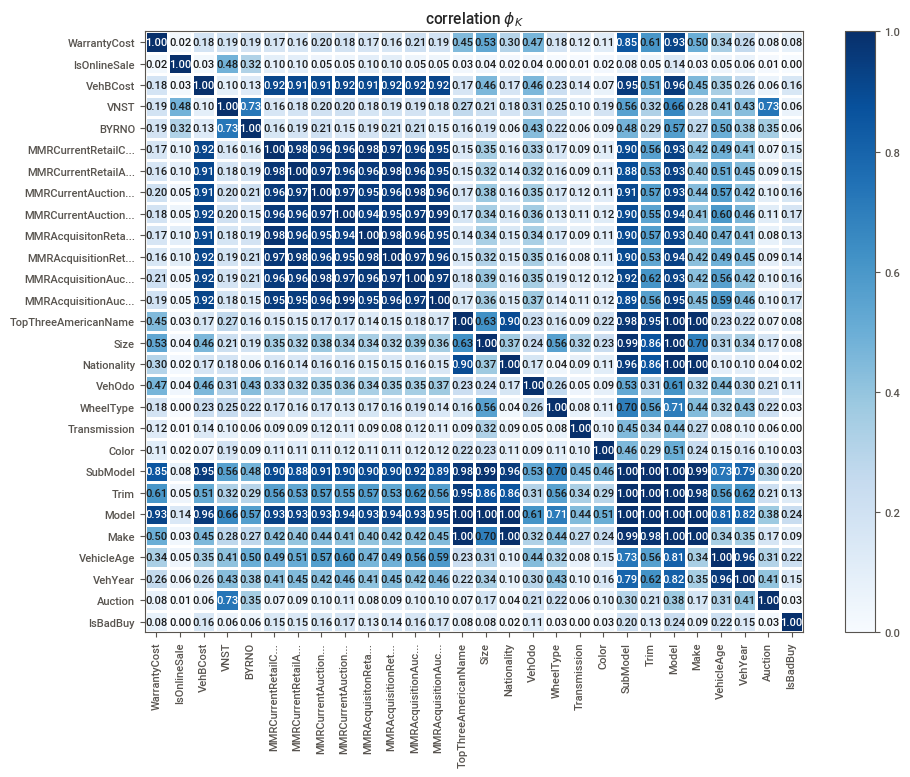

In [40]:

from phik.report import plot_correlation_matrix
import matplotlib.pyplot as plt
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=0.8,
                        figsize=(10,8))
plt.tight_layout()

It looks like VehBCost, MMR...features, Trim, Model, subModel and VehicleAge are relatvely strong features to determine whether a purchase at auction is bad buy or not.  

## Preprocess & Feature Engineering

In [67]:
df.columns

Index(['RefId', 'IsBadBuy', 'PurchDate', 'Auction', 'VehYear', 'VehicleAge',
       'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission',
       'WheelTypeID', 'WheelType', 'VehOdo', 'Nationality', 'Size',
       'TopThreeAmericanName', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'PRIMEUNIT', 'AUCGUART', 'BYRNO',
       'VNZIP1', 'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost'],
      dtype='object')

In [5]:
nominal_cols = [  'TopThreeAmericanName', 'Color', 'Transmission', 
                 'Nationality', 'Size']


num_cols =  ['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
                        'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
                        'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
                        'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice']

res_cols=['Auction',  'IsOnlineSale', 'Make',  'VNST',
        'VehOdo', 'VehicleAge','WheelType','Trim','WarrantyCost','VehBCost']

df=df[df.VehicleAge>0]  # drop outliers where the 'VehicleAge' is 0

In [6]:

class Preprocessor(object):
    '''Class used to fill missing, transform outliers and create new MMR_avg and miles_per_year features'''


    def outlier_detector1(self,X,y=None): # for MMR... features
        X = pd.Series(X).copy()
        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1    
        lower_bound=q1 - (1.5 * iqr)
        upper_bound=q3 + (1.5 * iqr)
        return lower_bound, upper_bound  

    def outlier_detector2(self,X,y=None):  # for 'WarrantyCost' and 'VehBCost'
        X = pd.Series(X).copy()  
        lower_bound=X.quantile(0.01)
        upper_bound=X.quantile(0.99)
        return lower_bound, upper_bound 

    def avg_MMR_price(self,X,y=None):
         '''
        This function takes the average of the 8 variables of the auction average prices
        '''
         df=X.copy()
         MMR_averages = ['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
                        'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
                        'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
                        'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice']
                        
    
         df['MMR_avg'] = sum(df[ave] for ave in  MMR_averages) /len( MMR_averages)
         df.drop(MMR_averages, axis=1,inplace=True)  
         return df


    def fit(self,X,y=None):
        df = X.copy()
        df_num= df[num_cols]
        df_nominal=df[nominal_cols]
        self.means = df_num.mean()
        self.mod=df_nominal.mode()
        self.cat_Make = df['Make'].value_counts().index[:15]
        self.lower_bound=[]
        self.upper_bound=[]
        for col in num_cols:
            self.lower_bound.append(self.outlier_detector1(df_num[col])[0])
            self.upper_bound.append(self.outlier_detector1(df_num[col])[1])
        self.lower_bound_WC=self.outlier_detector2(df['WarrantyCost'])[0]
        self.upper_bound_WC=self.outlier_detector2(df['WarrantyCost'])[1]
        self.lower_bound_VC=self.outlier_detector2(df['VehBCost'])[0]
        self.upper_bound_VC=self.outlier_detector2(df['VehBCost'])[1]

 
    
    def transform(self,X,y=None):
        df = X.copy()
        df_num= df[num_cols]
        df_nominal=df[nominal_cols]
        #fill missing with mean for numerical features
        df_num= df_num.fillna(self.means)
        # cap outliers in the MMR features 
        for i in range(len(num_cols)):
            df_num[num_cols[i]]=df_num[num_cols[i]].map(lambda x: self.upper_bound[i] if x>self.upper_bound[i] else x)
            df_num[num_cols[i]]=df_num[num_cols[i]].map(lambda x: self.lower_bound[i] if x<self.lower_bound[i] else x)
      
        df_num=self.avg_MMR_price(df_num)  
        # fill missing with mode for categorical features
        df_nominal=df_nominal.fillna({k: v[0] for k, v in self.mod.to_dict().items()})
        df_res=df[res_cols]

        # cap outliers in WarrantyCost and VehBCost
        df_res['WarrantyCost']=df_res['WarrantyCost'].map(lambda x: self.upper_bound_WC if x>self.upper_bound_WC else x)
        df_res['WarrantyCost']=df_res['WarrantyCost'].map(lambda x: self.lower_bound_WC if x<self.lower_bound_WC else x)
        df_res['VehBCost']=df_res['VehBCost'].map(lambda x: self.upper_bound_VC if x>self.upper_bound_VC else x)
        df_res['VehBCost']=df_res['VehBCost'].map(lambda x: self.lower_bound_VC if x<self.lower_bound_VC else x)

        df=pd.concat([df_num, df_nominal,df_res], axis=1)
        df['miles_per_year']=df['VehOdo']/df['VehicleAge'] #create new feature
        df['WheelType']=df['WheelType'].fillna("Unknown") # fill unknown for missing 
        df['Trim']=df['Trim'].fillna("Unknown") # fill unknown for missing 
        df.loc[df.Transmission=='Manual', 'Transmission'] = 'MANUAL' #convert 'Manual' to 'MANUAL'
        df.loc[(~df.Make.isin(self.cat_Make)), 'Make'] = 'Other' #collapse categories in Make 
     
        return df
    
    def fit_transform(self,X,y=None):
        self.fit(X)
        return self.transform(X)

In [7]:
prep=Preprocessor()


<ipython-input-90-698a0716f2a1>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res['WarrantyCost']=df_res['WarrantyCost'].map(lambda x: self.upper_bound_WC if x>self.upper_bound_WC else x)
<ipython-input-90-698a0716f2a1>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res['WarrantyCost']=df_res['WarrantyCost'].map(lambda x: self.lower_bound_WC if x<self.lower_bound_WC else x)
<ipython-input-90-698a0716f2a1>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

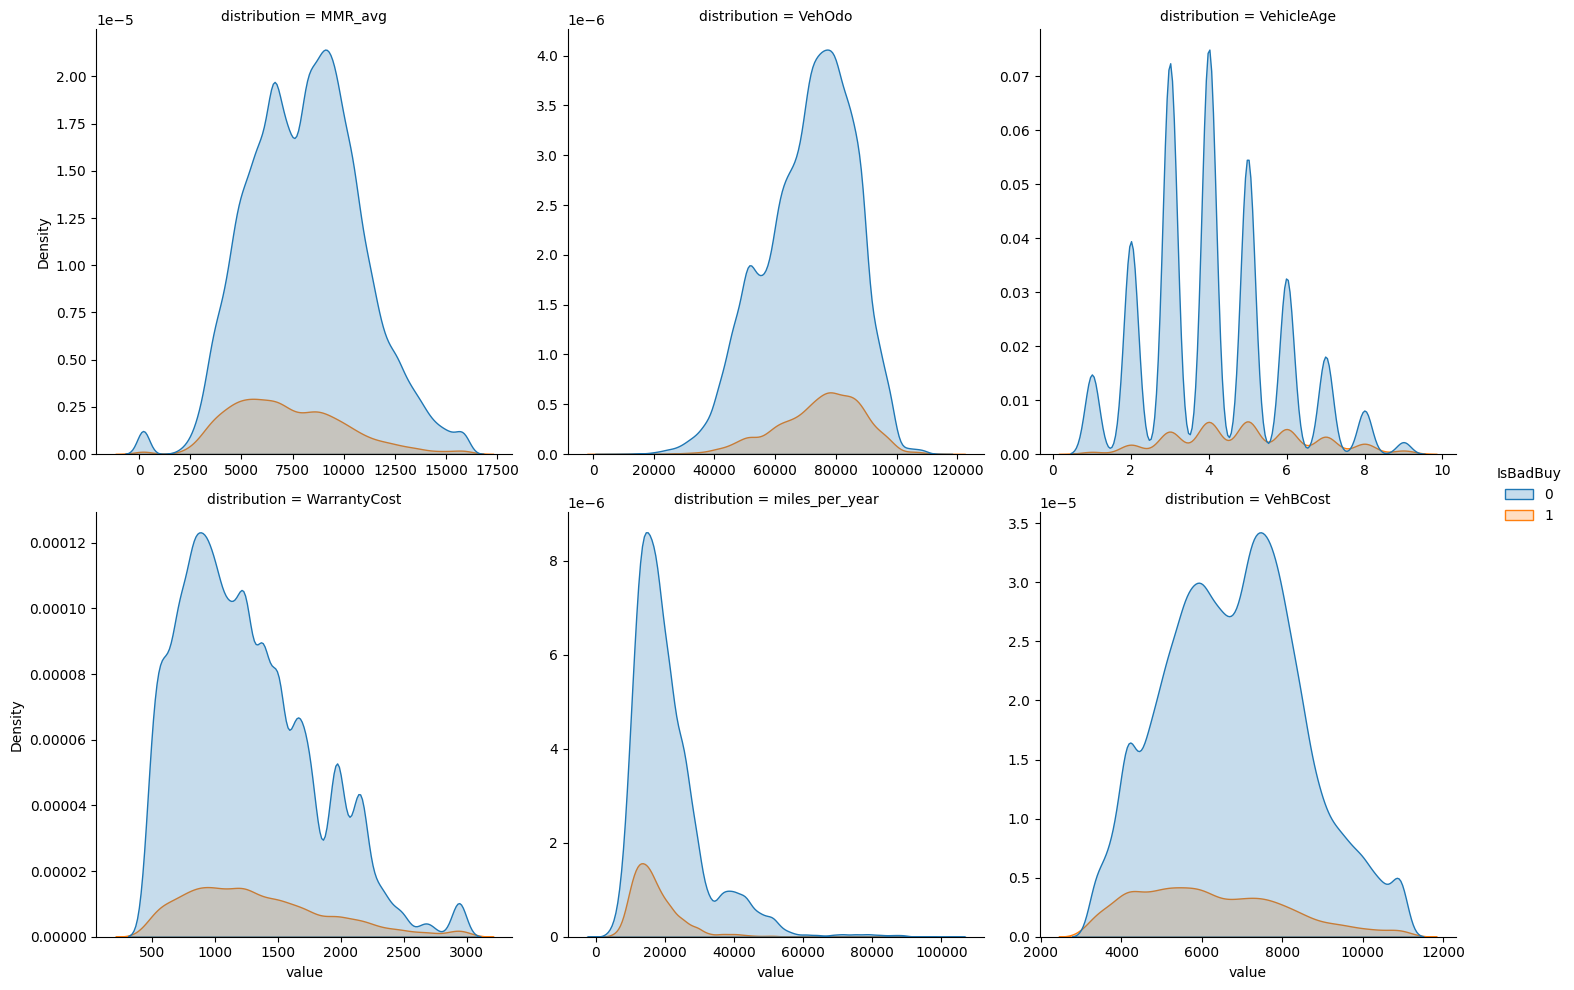

In [94]:
# Visualize the distributions of numerical features and counts for categorical features by IsBadBuy
#after preprossing (Preprocessor class)

df_clean=pd.concat([prep.fit_transform(df),df['IsBadBuy']],axis=1)
num_col=['MMR_avg','VehOdo',	'VehicleAge',	'WarrantyCost','miles_per_year','VehBCost','IsBadBuy']
cat_col=['TopThreeAmericanName', 'Color', 'Transmission',
       'Nationality', 'Size', 'Auction', 'IsOnlineSale', 'Make', 'VNST',
       'WheelType','Trim']

dfm = df_clean[num_col].melt(id_vars='IsBadBuy', var_name='distribution')
# plot
sns.displot(kind='kde', data=dfm, col='distribution', col_wrap=3, x='value', hue='IsBadBuy', fill=True, facet_kws={'sharey': False, 'sharex': False})


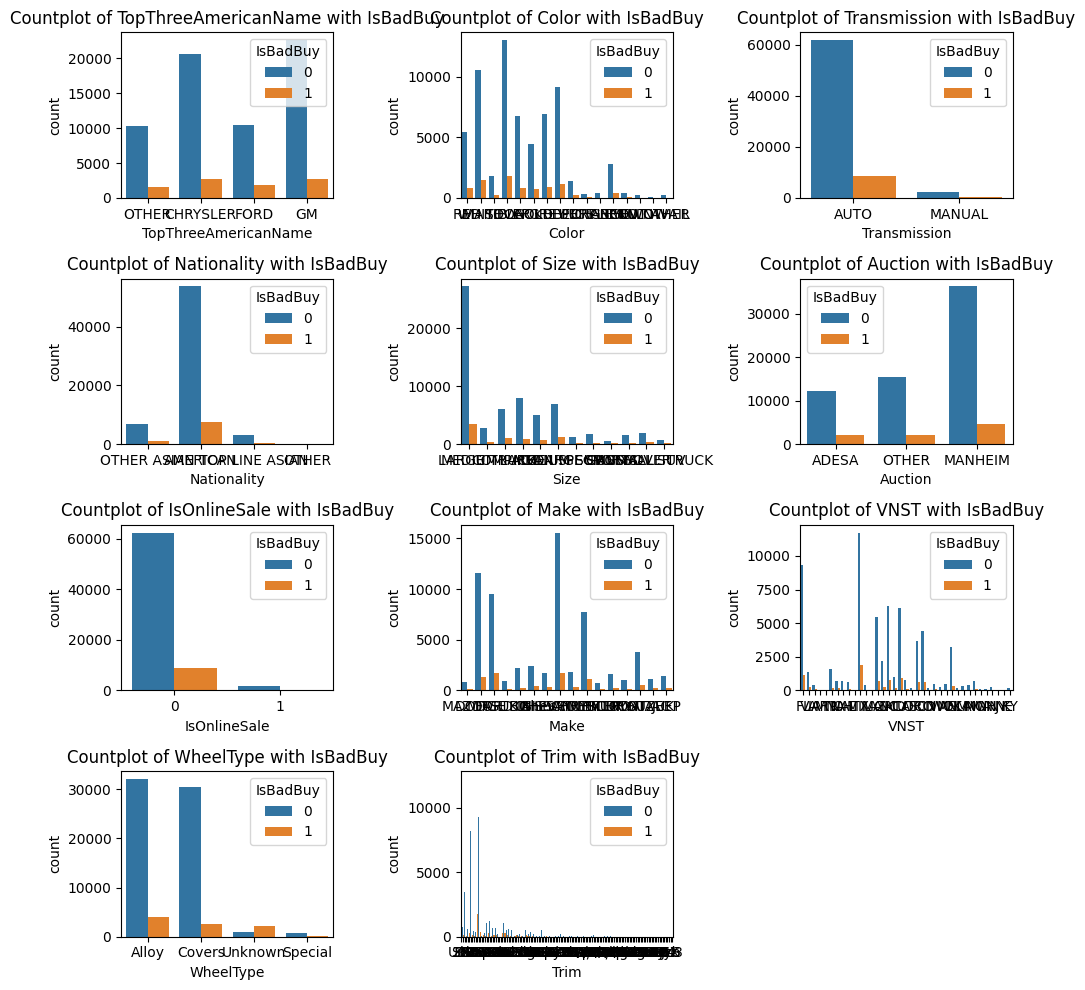

In [95]:

cat_features = df_clean[['TopThreeAmericanName', 'Color', 'Transmission',
       'Nationality', 'Size', 'Auction', 'IsOnlineSale', 'Make', 'VNST',
        'WheelType','Trim','IsBadBuy']]

fig, axes = plt.subplots(4, 3, figsize=(10, 10))  # Create a 4x3 grid of subplots

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot the countplot for each column with hue
for i, column in enumerate(cat_features.columns[:-1]):  # Exclude the last column (hue column)
    sns.countplot(data=cat_features, x=column, hue='IsBadBuy', ax=axes[i])  # Assign the subplot
    axes[i].set_title(f"Countplot of {column} with IsBadBuy")  # Set the title of the subplot

# Remove any unused subplots
for j in range(len(cat_features.columns)-1, len(axes)):
    fig.delaxes(axes[j])
    
fig.tight_layout()
plt.show()

The above distribution of numerical featuers look more normal after transferring outliers. It noticed that the distribution of numerical features are similar among isBadBuy but the counts for categorical features are different, indicating the categorical features may be more useful to predict isBadBuy. 

Transform categorical features

In [8]:
# to transform categorcal features


cat_columns=[ 'TopThreeAmericanName', 'Color', 'Transmission', 
                 'Nationality', 'Size','Auction', 'IsOnlineSale', 'Make',  'VNST', 'WheelType']
cat_transformer = make_column_transformer((category_encoders.CountEncoder(),['Trim']), # frequency encoding 
                                          
                                             (OneHotEncoder(sparse_output=False), cat_columns),  # one-hot encoding
                                                                          
                                            remainder='passthrough' )



## Modeling and Evaluation


Since we are dealing with a binary classification problem with the target feature (IsBadBuy), there are various ML algorithms to consider, such as logistic regression, random forest, gradient boosting, XGBoost, and MLP. To establish a baseline, I created a dummy classifier as the baseline and a 'userful' ML model should perform better than the baseline. Logistic regression was chosen and conducted hyperparameter tuning.

Given the imbalanced nature of the target feature, where the majority class dominates, ML algorithms may exhibit a bias towards the majority class. To address this, I employed down-sampling and balanced class labels during training by specifying class weights if feasible. Since the number of features exceeds 100, I applied feature selection using SelectKBest and retained the top 40 features. Additionally, feature normalization was performed to prepare the data for logistic regression.

Regarding evaluation metrics, the primary goal of this project is to predict whether a car purchased at the auction is a "Kick" (bad buy). Bad buys result in revenue loss for auto dealers, so it is crucial to identify as many bad buys as possible. Therefore, recall is a critical metric to consider, as an increase in the recall score can lead to increased revenue by reducing false negatives. There is a trade-off between precision and recall. To account for both precision and recall, the F1 score is also utilized. Accuracy is not appropriate for imbalanced classification problems. The ROC AUC is valuable as it indicates the classifier's overall prediction ability, regardless of the classification threshold.

Since precision and recall scores are influenced by the classification threshold, threshold tuning was conducted to select the optimal threshold for achieving the desired recall score while maintaining an acceptable precision score.

Split train and test sets

In [9]:
#split train and test sets (stratified split based on target)
from sklearn.model_selection import train_test_split

target='IsBadBuy'
y=df[target]
X=df[num_cols+nominal_cols+res_cols]
# create train test split
X_train, X_test, y_train, y_test = train_test_split( X,  y, test_size=0.3, stratify=y,random_state=0)  

In [10]:
print(y_train.value_counts(normalize=True)) #imbalacned labels in the train and test set
y_test.value_counts(normalize=True) 

0    0.877011
1    0.122989
Name: IsBadBuy, dtype: float64


0    0.877004
1    0.122996
Name: IsBadBuy, dtype: float64

Build pipeline to train model 

In [11]:
def build_ml_pipeline(classifier):

    steps = [ 

          ('prep',   Preprocessor()),                            
           ('CTN' ,cat_transformer),
           ('minMax', MinMaxScaler()),
           ('select_f', SelectKBest(f_classif, k = 40)),
          ('downSample', RandomUnderSampler()),
         ('model', classifier)]

    pipe=Pipeline(steps)
    return pipe

**Baseline model: Dummy classifier**

In [187]:
# use the 'stratified' rule. The predictions are generated randomly, however, the distribution of classes from the training set is preserved. 
dummy=DummyClassifier(strategy='stratified', random_state=42)
model=dummy.fit(X_train, y_train)

In [188]:
y_train_pred = model.predict(X_train)
y_test_pred=model.predict(X_test)

Evaluate performance on test data

In [189]:
acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
pre = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred)
print("Model evaluation result on test data: ")
print("F1 Score : {:.4%}".format(f1))
print("ROC AUC : {:.4%}".format(auc))
print("Accuracy : {:.4%}".format(acc))
print("Precision : {:.4%}".format(pre))
print("Recall : {:.4%}".format(rec))

Model evaluation result on test data: 
F1 Score : 12.4514%
ROC AUC : 50.0724%
Accuracy : 78.4197%
Precision : 12.4260%
Recall : 12.4768%


In [117]:

target_names = ['not bad buy', 'bad buy'] 
print(classification_report(y_test, y_test_pred, target_names=target_names))

              precision    recall  f1-score   support

 not bad buy       0.88      0.88      0.88     19202
     bad buy       0.12      0.12      0.12      2693

    accuracy                           0.78     21895
   macro avg       0.50      0.50      0.50     21895
weighted avg       0.78      0.78      0.78     21895



The dummy classifier model that makes predictions without trying to find patterns in the data. It shows that recall, precision and F-1 scores (for the minority class) are very low (~12%) in the dummpy classifier. The precision, recall and F1-score are much better in the marjority class than the minority class, which is common for imbalanced classification. 

**Model selection with cross validation**

In [12]:
classifiers = [
    LogisticRegression(class_weight='balanced',max_iter=500),
    RandomForestClassifier(class_weight='balanced'),
    GradientBoostingClassifier(),
    XGBClassifier(scale_pos_weight=(1 - y.mean()),
           n_jobs=-1)
    ]

In [13]:
import pandas as pd
pd.options.mode.chained_assignment = None 

In [14]:
skfold = StratifiedKFold(n_splits=5, shuffle=True)
for classifier in classifiers:
  pipeline = build_ml_pipeline(classifier)
  %time scores = cross_val_score(pipeline, X_train,y_train, cv=skfold, scoring='f1')
  print(classifier.__class__.__name__, ': f1 value is %.3f (%.3f)' % (np.mean(scores)*100, np.std(scores)*100))
  print('==============')

CPU times: user 4.4 s, sys: 1.39 s, total: 5.79 s
Wall time: 4.88 s
LogisticRegression : f1 value is 36.135 (0.820)
CPU times: user 11.1 s, sys: 193 ms, total: 11.3 s
Wall time: 11.3 s
RandomForestClassifier : f1 value is 33.474 (0.630)
CPU times: user 15 s, sys: 142 ms, total: 15.2 s
Wall time: 15.2 s
GradientBoostingClassifier : f1 value is 35.652 (0.441)
CPU times: user 19.1 s, sys: 166 ms, total: 19.3 s
Wall time: 11.9 s
XGBClassifier : f1 value is 34.084 (0.616)


The results indicate that logistic regression and gradient boosting outperform random forest and XGB. Given its fast training speed and ease of interpretation, I have decided to use logistic regression as the preferred model. However, it is worth noting that other models may perform exceptionally well after hyperparameter tuning. If time permits, a more comprehensive search can be conducted to explore the potential of other models 

**Build model with logsitic regression**





In [195]:
pipeline = build_ml_pipeline(LogisticRegression(class_weight='balanced',max_iter=500)) # LR tends to only predict the majority class data so balance class distribution
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep', <__main__.Preprocessor object at 0x7f0e991831c0>),
                ('CTN',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('countencoder',
                                                  CountEncoder(combine_min_nan_groups=True),
                                                  ['Trim']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['TopThreeAmericanName',
                                                   'Color', 'Transmission',
                                                   'Nationality', 'Size',
                                                   'Auction', 'IsOnlineSale',
                                                   'Make', 'VNST',
                                                   'WheelType'])])),
                ('minMax', MinMaxScaler()), ('select_f', SelectKBest(k=40)),
                ('downSample', RandomUnderSampler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=500))])

In [196]:
y_train_pred = pipeline.predict(X_train)
y_test_pred=pipeline.predict(X_test)

Evaluate performance on test data

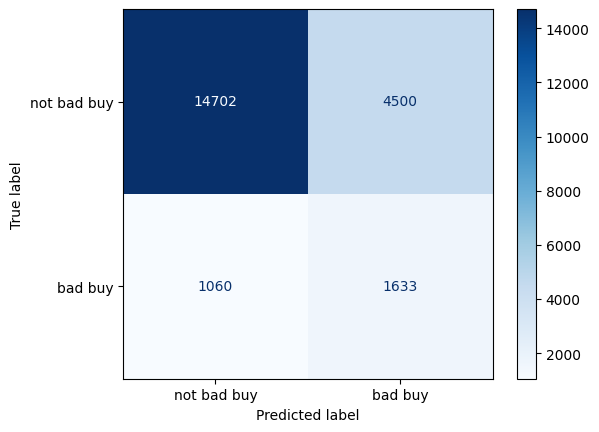

In [197]:

cm=confusion_matrix(y_test, y_test_pred)

# plot_confusion_matrix function is used to visualize the confusion matrix
ConfusionMatrixDisplay(cm,display_labels = ["not bad buy","bad buy"]).plot(cmap=plt.cm.Blues)
plt.show()

In [198]:
acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
pre = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred)

In [199]:
print("Model evaluation result on test data: ")
print("F1 Score : {:.4%}".format(f1))
print("ROC AUC : {:.4%}".format(auc))
print("Accuracy : {:.4%}".format(acc))
print("Precision : {:.4%}".format(pre))
print("Recall : {:.4%}".format(rec))

Model evaluation result on test data: 
F1 Score : 37.0043%
ROC AUC : 68.6018%
Accuracy : 74.6061%
Precision : 26.6264%
Recall : 60.6387%


In [200]:
target_names = ['not bad buy', 'bad buy'] 
print(classification_report(y_test, y_test_pred, target_names=target_names))

              precision    recall  f1-score   support

 not bad buy       0.93      0.77      0.84     19202
     bad buy       0.27      0.61      0.37      2693

    accuracy                           0.75     21895
   macro avg       0.60      0.69      0.61     21895
weighted avg       0.85      0.75      0.78     21895



## Hypeterparameter tunning for logistic regression

In [232]:


param_grid = {
    'model__penalty' : ['l1','l2', 'elasticnet'], 
    'model__C'       : np.logspace(-3, 3, 7),
    'model__solver'  : ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
    'model__max_iter': [300,500,1000]
}

In [215]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
skfold = StratifiedKFold(n_splits=5, shuffle=True)

grid = GridSearchCV(build_ml_pipeline(LogisticRegression(class_weight='balanced')), cv=skfold, param_grid=param_grid, scoring='f1')
grid.fit(X_train, y_train)

#search = BayesSearchCV(build_ml_pipeline(LogisticRegression(class_weight='balanced')), search_spaces=param_grid, scoring = 'recall',n_jobs=-1, cv=skfold)
#search.fit(X_train, y_train)

In [ ]:
print("Best recall is %.3f" % grid.best_score_)
print("Params are %s" % grid.best_params_)

**Re-train the logisic regression**

In [290]:
pipeline = build_ml_pipeline(LogisticRegression( #logisitc regression 
    C=8,
    penalty='l2',
    solver='saga',
    max_iter=500,
    class_weight='balanced'
))
model_s=pipeline.fit(X_train, y_train)

In [291]:
y_train_pred = model_s.predict(X_train)
y_test_pred=model_s.predict(X_test)

Evaluate performance on test data

In [292]:
acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
pre = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred)

print("Model evaluation result on test data: ")
print("F1 Score : {:.4%}".format(f1))
print("ROC AUC : {:.4%}".format(auc))
print("Accuracy : {:.4%}".format(acc))
print("Precision : {:.4%}".format(pre))
print("Recall : {:.4%}".format(rec))

Model evaluation result on test data: 
F1 Score : 36.3256%
ROC AUC : 68.2818%
Accuracy : 73.5967%
Precision : 25.8221%
Recall : 61.2328%


In [293]:
from sklearn.metrics import classification_report 
target_names = ['not bad buy', 'bad buy'] 
print(classification_report(y_test, y_test_pred, target_names=target_names))

              precision    recall  f1-score   support

 not bad buy       0.93      0.75      0.83     19202
     bad buy       0.26      0.61      0.36      2693

    accuracy                           0.74     21895
   macro avg       0.60      0.68      0.60     21895
weighted avg       0.85      0.74      0.78     21895



**feature importance**

In [299]:
pipeline[0].fit_transform(X_train).columns

Index(['MMR_avg', 'TopThreeAmericanName', 'Color', 'Transmission',
       'Nationality', 'Size', 'Auction', 'IsOnlineSale', 'Make', 'VNST',
       'VehOdo', 'VehicleAge', 'WheelType', 'Trim', 'WarrantyCost', 'VehBCost',
       'miles_per_year'],
      dtype='object')

In [294]:
res_names=list(set(pipeline[0].fit_transform(X_train).columns) - set(cat_columns))
res_names.remove('Trim')
ohe_names=list(pipeline[1].named_transformers_['onehotencoder'].get_feature_names_out(cat_columns))
tot_names=['Trim']+ohe_names+res_names
mask=pipeline[3].get_support()
selected_names = np.array(tot_names)[mask]

In [295]:

pipeline.steps[5][1].coef_


array([[ 0.10206802, -0.03590459,  0.39901503, -0.30492615, -0.10373673,
         0.10543341,  0.05818428,  0.09327718,  0.32127112, -0.01543517,
         0.5305587 ,  0.02408729,  0.30939386,  0.23469912,  0.37209022,
         0.10575989,  0.33573243, -0.21173189, -0.12186554, -0.55841296,
         0.11011224,  0.0895429 , -0.46177931,  0.21727785, -0.07651261,
         0.58868199, -0.22796294,  0.08783574,  0.5477107 ,  0.24295693,
         0.40605225, -0.04058912, -0.13630782,  3.27794835,  0.88359892,
         1.2536266 ,  1.35619137,  0.27484533, -1.49464774, -1.8558732 ]])

                          feature  importance
33              WheelType_Unknown    3.277948
39                        MMR_avg    1.855873
38                         VehOdo    1.494648
36                   WarrantyCost    1.356191
35                       VehBCost    1.253627
34                 miles_per_year    0.883599
25                    Make_SUZUKI    0.588682
19                      Make_FORD    0.558413
28                        VNST_PA    0.547711
10                 Size_LARGE SUV    0.530559
22                   Make_MERCURY    0.461779
30                        VNST_VA    0.406052
2       TopThreeAmericanName_FORD    0.399015
14                    Size_SPORTS    0.372090
16                Auction_MANHEIM    0.335732
8                    Size_COMPACT    0.321271
12                Size_MEDIUM SUV    0.309394
3         TopThreeAmericanName_GM    0.304926
37                     VehicleAge    0.274845
29                        VNST_TX    0.242957
13                 Size_SPECIALTY 

<Figure size 1600x2000 with 0 Axes>

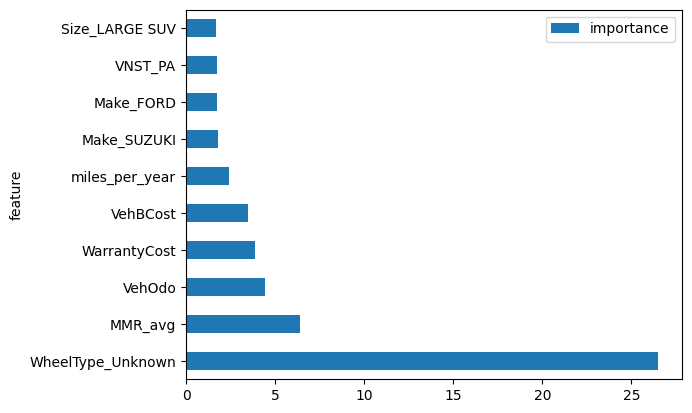

In [296]:
feature_names=selected_names
importances=abs(pipeline.steps[5][1].coef_)
df_importances = pd.DataFrame(
    {"feature":feature_names, "importance":importances.flatten()}).sort_values("importance", ascending=False)
print(df_importances)

# get feature importance
plt.figure(figsize = (16,20))
weight=np.transpose(importances)
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, weight)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
ax = feature_importance[:10].plot.barh(x='feature', y='importance')
plt.show()

The results show the logisitc regression model perform much better than the dummy classifier based on all the metrics (recall, precision, F1-score and ROC AUC). Recall score for the minority class improved a lot compared to the dummy classifier (0.66 vs. 0.12).

## Threshold tuning for recall 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

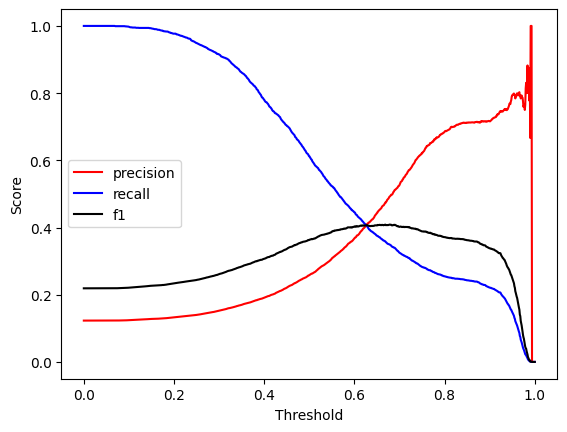

threshold for 65% recall: 0.4805
precison score at 65% recall: 0.244


In [297]:
from sklearn.metrics import precision_score, recall_score, f1_score
y_pred_prob=model_s.predict_proba(X_test)[:,1]
thresholds = np.linspace(0, 1, 1000)
precisions = []
recalls = []
f1s = []
ave = "binary"

for cut in thresholds:
    y_test_predic = (y_pred_prob > cut).astype(int)
    precisions.append(precision_score(y_test, y_test_predic, average=ave))
    recalls.append(recall_score(y_test, y_test_predic, average=ave))
    f1s.append(f1_score(y_test, y_test_predic, average=ave))

plt.plot(thresholds, precisions, color="red", label="precision")
plt.plot(thresholds, recalls, color="blue", label="recall")
plt.plot(thresholds, f1s, color="black", label="f1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

index=np.argmin(np.array(recalls) >= 0.65)
thr_65_recall = round(thresholds[index], ndigits = 4)
pre_65_recall =round(precisions[index], ndigits = 3)
print('threshold for 65% recall:', thr_65_recall)
print('precison score at 65% recall:',pre_65_recall)

**Conclusion**


In summary, this project addresses the challenge faced by auto dealerships when purchasing used cars at auto auctions, where some cars turn out to be 'kicks' and cannot be sold to customers. These kicks result in revenue loss for dealers. To mitigate this issue, I developed a 'kicks' detector using historical data to predict which cars are at a higher risk of being kicks and captured important features that contributed to 'kicks'.

The logistic regression model significantly improved the recall score by approximately 400% (61% vs. 12%) compared to a dummy classifier, increased the F-1 score by about 200% (35% vs. 12%) and increased the ROC AUC about 37% (0.68 vs. 0.5). The It is important to note that recall and precision scores depend on the threshold and there is a trade-off between them. For instance, setting the threshold at 0.48  can achieve a recall score of 65% and precision score of 24.4%. The increase in the recall score directly contributes to increased revenue.

The top eight features that contribute to the risk of being a kick are WheelType_Unknown, MMR_avg, VehOdo, WarrantyCost, VehBCost, miles_per_year, Make_SUZUKI, and Make_FORD. It appears WheelType is an important features, but the WheelType_Unknown lacks informative value since it represents missing entries filled with 'Unknown'. It would be beneficial to gather additional information about the WheelType and incorporate it into the training process.

Moving forward, there are several aspects to consider for further improvements:

* Exploring better approaches for handling missing values, such as trying different imputation strategies.
* Exploring additional features such as purchase date, model, submodel, and creating new features based on the number of cylinders, injection types, driving system, and body information from model/submodel.
* Seeking input from domain experts to identify and create other potentially useful features.
* Exploring different feature selection strategies such as Recursive Feature Elimination with Cross-Validation (RFECV).
* Fine-tuning and exploring other machine learning models, e.g, gradient boosting/XGB that may better capture the nonlinear relationships between features and kicks
* Considering an ensemble approach with a combination of different models to further enhance performance.

